In [1]:
import requests
import numpy as np
import pandas as pd
from collections import Counter
import seaborn as sns
%matplotlib inline

In [142]:
draft_order = ['Aaron', 'John', 'Brian', 'Josh', 'Brad', 'Micah', 'Matt', 'Jon', 'Ryan', 'Colin', 
               'Matt', 'Colin', 'Brian', 'Ryan', 'Brad', 'John', 'Jon', 'Josh', 'Micah', 'Aaron', 
               'Jon', 'Micah', 'Ryan', 'Colin', 'Josh', 'Aaron', 'Brad', 'Matt', 'John', 'Brian','','']

In [143]:
# for determining optimal assigments given current scores
# must run code below before this
team_ranking = df_union.groupby(["team"])[["win"]].sum().sort_values('win', ascending=False)
team_assignment = {t:p for t,p in zip(team_ranking.index, draft_order)}
team_assignment

{'Arizona': '',
 'Atlanta': 'Aaron',
 'Baltimore': 'Colin',
 'Buffalo': 'Josh',
 'Carolina': 'Colin',
 'Chicago': 'Ryan',
 'Cincinnati': 'Brian',
 'Cleveland': 'Colin',
 'Dallas': 'Ryan',
 'Denver': 'Micah',
 'Detroit': 'Jon',
 'Green Bay': 'Aaron',
 'Houston': 'John',
 'Indianapolis': 'Matt',
 'Jacksonville': 'Brad',
 'Kansas City': 'John',
 'L.A. Chargers': 'Jon',
 'L.A. Rams': 'Aaron',
 'Miami': 'Josh',
 'Minnesota': 'Jon',
 'N.Y. Giants': 'Brad',
 'N.Y. Jets': 'John',
 'New England': 'Micah',
 'New Orleans': 'Matt',
 'Oakland': 'Brian',
 'Philadelphia': 'Brad',
 'Pittsburgh': 'Josh',
 'San Francisco': '',
 'Seattle': 'Brian',
 'Tampa Bay': 'Ryan',
 'Tennessee': 'Matt',
 'Washington': 'Micah'}

In [148]:
# got team names from set(df.team1).union(df.team2)
# Arizona and Cleveland unassigned
team_assignment = {
 'Arizona': '',
 'Atlanta': 'Matt',
 'Baltimore': 'John',
 'Buffalo': 'Ryan',
 'Carolina': 'Ryan',
 'Chicago': 'Aaron',
 'Cincinnati': 'Jon',
 'Cleveland': '',
 'Dallas': 'Brad',
 'Denver': 'Micah',
 'Detroit': 'Colin',
 'Green Bay': 'Jon',
 'Houston': 'Colin',
 'Indianapolis': 'Colin',
 'Jacksonville': 'Brian',
 'Kansas City': 'Ryan',
 'L.A. Chargers': 'Matt',
 'L.A. Rams': 'John',
 'Miami': 'Brad',
 'Minnesota': 'Josh',
 'N.Y. Giants': 'John',
 'N.Y. Jets': 'Josh',
 'New England': 'Aaron',
 'New Orleans': 'Micah',
 'Oakland': 'Matt',
 'Philadelphia': 'Brad',
 'Pittsburgh': 'Brian',
 'San Francisco': 'Aaron',
 'Seattle': 'Jon',
 'Tampa Bay': 'Brian',
 'Tennessee': 'Micah',
 'Washington': 'Josh'}

In [149]:
persons = sorted(list(set(p for p in team_assignment.values() if p!='')))
persons

['Aaron',
 'Brad',
 'Brian',
 'Colin',
 'John',
 'Jon',
 'Josh',
 'Matt',
 'Micah',
 'Ryan']

In [150]:
def team_split(game):
    """split team text"""
    return game.split('<td class="td text team')[1:]

def team_name(team_raw):
    """extract team name"""
    part = team_raw.split('">')[1]
    return part.split('</td>')[0].strip()

def team_probability(team_raw):
    """extract win probability for team
    apparently they put 'loser' and 'winner' in the class name when the game is complete"""
    if 'loser">' in team_raw:
        return 0
    elif 'winner">' in team_raw:
        return 1
    else: 
        part = team_raw.split('%</td><td class="td number score">')[0]
        return float(part.split('>')[-1])/100
    
def game_dates(raw):
    """get game dates"""
    games = raw.split('<table class="game-body">')
    date_class = '<div class="day"><h4 class="h4">'
    dates = []
    for g in games:
        if date_class in g:
            game_date = g.split(date_class)[1].split('</h4>')[0]
        dates.append(game_date)
    return dates[:256]

def game_weeks(raw):
    """get game weeks"""
    games = raw.split('<table class="game-body">')
    week_class = '<h3 class="h3">Week '
    weeks = []
    for g in games:
        if week_class in g:
            game_week = int(g.split(week_class)[1].split('</h3>')[0])
        weeks.append(game_week)
    return weeks[:256]

In [151]:
# get full html of page
r = requests.get("https://projects.fivethirtyeight.com/2018-nfl-predictions/games/")

raw = r.text

# html for each game table
# first element is not relevant
games = raw.split('<table class="game-body">')[1:]
len(games)

256

In [152]:
weeks = game_weeks(raw)
set(weeks)

{1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17}

In [153]:
# function example usage
game = games[100]
team1, team2 = team_split(game)
print(team_name(team1), team_name(team2))
print(team_probability(team1), team_probability(team2))

Atlanta New Orleans
0.33 0.67


In [154]:
# build game probabilities data frame
data = []
for game in games:
    team1, team2 = team_split(game)
    team1_name, team2_name = team_name(team1), team_name(team2)
    person1, person2 = team_assignment[team1_name], team_assignment[team2_name]
    info = [team1_name, team2_name, team_probability(team1), team_probability(team2), person1, person2]
    data.append(info)
    
cols = ["team1", "team2", "prob1", "prob2", "person1", "person2"]
df = pd.DataFrame(data, columns=cols)
df.to_csv("games.txt", index=False)
df["week"] = weeks
df[:5]

,team1,team2,prob1,prob2,person1,person2,week
0,Indianapolis,New England,0.0,1.0,Colin,Aaron,5
1,Atlanta,Pittsburgh,0.0,1.0,Matt,Brian,5
2,Baltimore,Cleveland,0.0,1.0,John,,5
3,Denver,N.Y. Jets,0.0,1.0,Micah,Josh,5
4,Green Bay,Detroit,0.0,1.0,Jon,Colin,5


In [155]:
# test scenarios
"""
df.loc[df.team1=="Detroit", "prob1"] = 1
df.loc[df.team1=="Detroit", "prob2"] = 0
df.loc[df.team2=="Detroit", "prob1"] = 0
df.loc[df.team2=="Detroit", "prob2"] = 1
df[(df.team1=="Detroit") | (df.team2=="Detroit")]
"""

'\ndf.loc[df.team1=="Detroit", "prob1"] = 1\ndf.loc[df.team1=="Detroit", "prob2"] = 0\ndf.loc[df.team2=="Detroit", "prob1"] = 0\ndf.loc[df.team2=="Detroit", "prob2"] = 1\ndf[(df.team1=="Detroit") | (df.team2=="Detroit")]\n'

In [156]:
# current and best possible score by person
current = []
for p in persons:
    certain_win = possible_win = ((df.person1==p) & (df.prob1==1)) | ((df.person2==p) & (df.prob2==1))
    possible_win = ((df.person1==p) & (df.prob1>0)) | ((df.person2==p) & (df.prob2>0))
    current.append([p, certain_win.sum(), possible_win.sum()])
    
df_current = pd.DataFrame(current, columns=['person', 'wins', 'max_possible']).set_index("person")
df_formatted = df_current.sort_values(['wins','max_possible'], ascending=False)
df_formatted.to_csv("scores.txt", sep=" ", header=False)
df_formatted

,wins,max_possible
person,,
Ryan,10,44
John,9,42
Micah,8,42
Jon,8,40
Brian,7,40
Aaron,7,39
Brad,7,39
Josh,6,40
Matt,5,37


In [157]:
# simulate seasons
n_sims = 20000
sims = []
for index, g in df.iterrows():
    a = [g['person1'], g['person2']]
    p = [g['prob1'], g['prob2']]
    if sum(p) != 0:
        game_sims = np.random.choice(a, n_sims, p=p)
    sims.append(game_sims)

sims = np.array(sims).T
sims.shape

(20000, 256)

In [158]:
# aggregate seasons into scores for each person
df_wins = pd.DataFrame([Counter(s) for s in sims])[persons]
print(df_wins.shape)
df_wins[:5]

(20000, 10)


,Aaron,Brad,Brian,Colin,John,Jon,Josh,Matt,Micah,Ryan
0,26,33,22,18,23,25,25,24,19,33
1,27,25,26,20,27,26,21,22,24,31
2,23,28,26,18,29,25,19,25,24,30
3,23,30,20,20,26,30,23,23,25,28
4,22,27,21,23,31,25,22,22,22,30


In [159]:
# use min method because ties take from following placements
# mistakenly used dense at first
df_rank = df_wins.rank(axis=1, method="min", ascending=False).astype(int)
df_rank[:5]

,Aaron,Brad,Brian,Colin,John,Jon,Josh,Matt,Micah,Ryan
0,3,1,8,10,7,4,4,6,9,1
1,2,6,4,10,2,4,9,8,7,1
2,8,3,4,10,2,5,9,5,7,1
3,6,1,9,9,4,1,6,6,5,3
4,6,3,10,5,1,4,6,6,6,2


In [160]:
rank1 = (df_rank==1).sum(0) / n_sims
rank2 = (df_rank==2).sum(0) / n_sims
rank3 = (df_rank==3).sum(0) / n_sims

probs = pd.concat([rank1, rank2, rank3], axis=1)
probs.columns = ["1", "2", "3"]
probs.sort_values("1", ascending=False).style.format("{:.1%}")

,1,2,3
Ryan,63.3%,17.9%,8.7%
Brad,14.8%,21.7%,18.4%
Brian,12.9%,19.1%,17.3%
John,10.4%,17.1%,16.2%
Micah,7.3%,13.1%,13.7%
Aaron,4.5%,9.5%,12.0%
Jon,4.3%,9.9%,13.0%
Josh,1.5%,4.5%,6.6%
Matt,0.3%,1.0%,2.0%
Colin,0.0%,0.1%,0.2%


In [136]:
formatted = (probs*100).sort_values("1", ascending=False).round(0).astype(int).astype(str)+'%'
formatted.to_csv("probabilities.txt", sep=" ", header=False)

In [137]:
person_sort = probs.sort_values("1", ascending=False).index

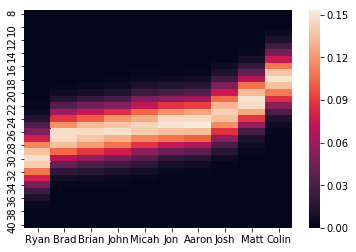

In [138]:
# score distribution for individual players
dist_df = []
for person in persons:
    dist_df.append(pd.DataFrame(df_wins.groupby(person).size() / n_sims))

dist_df = pd.concat(dist_df, axis=1).fillna(0)
dist_df.columns = persons
#dist_df.style.format("{:.1%}")
sns.heatmap(dist_df[person_sort], annot=False)

In [139]:
# union team data to compute wins
a = df[["person1", "team1", "prob1", "week"]].rename(columns={"person1":"person", "team1":"team", "prob1":"prob"})
b = df[["person2", "team2", "prob2", "week"]].rename(columns={"person2":"person", "team2":"team", "prob2":"prob"})
df_union = pd.concat([a, b], axis=0, ignore_index=True)
df_union["win"] = (df_union["prob"] == 1).astype(int)
totals = df_union.groupby(["person", "team"]).sum().reset_index()

In [140]:
# text for Notes app
text = ''
for person in persons:
    team_scores = totals[totals.person==person]
    score_text = "\n".join(" - " + team_scores.team + ": " + team_scores.win.astype(str))
    person_total = "TOTAL: " + str(team_scores.win.sum())
    person_max = "MAX: " + str(df_current.loc[person].max_possible)
    placement_prob = "1st 2nd 3rd: " + " ".join((probs.loc[person]*100).round(0).astype(int).astype(str) + "%")
    parts = [person, score_text, person_total, person_max, placement_prob, "\n"]
    text += "\n".join(parts)
    
open("report.txt", "w").write(text)

953

In [141]:
# scores by week
df_totals = df_union.groupby(['week', 'person']).sum().reset_index()
df_cumul = df_totals.pivot(index='week', columns='person', values='prob')[persons].cumsum()
df_cumul.round(1)

person,Aaron,Brad,Brian,Colin,John,Jon,Josh,Matt,Micah,Ryan
week,,,,,,,,,,
1,1.0,2.0,2.0,0.0,2.0,2.0,3.0,0.0,1.0,2.0
2,3.0,4.0,4.0,1.0,3.0,3.0,3.0,2.0,4.0,3.0
3,4.0,6.0,5.0,2.0,6.0,4.0,4.0,2.0,6.0,6.0
4,6.0,7.0,6.0,3.0,8.0,7.0,4.0,4.0,8.0,7.0
5,7.0,7.6,7.0,4.4,9.0,8.0,6.3,5.0,8.7,10.0
6,8.3,9.4,8.2,5.2,10.4,9.9,8.1,6.7,9.6,11.5
7,9.7,11.1,9.8,6.3,11.9,10.1,9.7,8.0,10.9,13.2
8,11.3,12.2,11.4,7.7,13.5,11.4,11.1,8.6,11.5,15.0
9,13.1,13.4,12.1,8.4,14.5,12.2,12.6,9.9,13.1,17.1
